# Kolektor Surface Defect Detection
TMM4128 - Machine Learning for Engineers - Semestral Project


### Import TensorFlow

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
# import pandas as pd
# import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageFilter 
# import math

In [2]:
import tensorflow as tf
# CUDA check
print("Number of GPUs: ", len(tf.config.list_physical_devices('GPU')))

Number of GPUs:  1


In [3]:
Categories = ["Undamaged", "Damaged"]
data_train = "./datasets/KolektorSDD2/train/"
data_test = "./datasets/KolektorSDD2/test/"
current_directory = os.getcwd()
print(current_directory)

flat_train = []
flat_train_GT = []
flat_test = []
flat_test_GT = []
damage_label_train = []
damage_label_test = []
img_name = []
X_train = []
X_test = []
y_train = []
y_test = []

# Average image size
img_height =  194 #194 # 636 # 388
img_width = 70 # 70 # 229 # 140
img_size = (img_height, img_width)

c:\Users\lukasvi\Documents\GitHub\NTNU-ML-KolektorSDD2


In [4]:
# Create TRAIN DATA

#Create path to folder
path = data_train

list_damaged = []
negative_max = 3000
negative_counter = 0 

Gauss = 0 # Gaussian filtering
Gauss_radius = 1

rotate_images = 1 # rotate defected images as up-sampling

#For-loop to go through all the contents in the folder
for img in os.listdir(path):
    #Distinguishing between Groundtruth pictures and Actual pictures
    image_path_GT = os.path.join(path,img)
    image_path = os.path.join(path,img[:5]+".png")

    if "GT" in img:
        img_array = cv2.imread(image_path_GT)
        #If the GT Image is Black, no damage is detected
        if np.all(img_array == 0): # OK
            if negative_counter < negative_max:
                y_train.append(0)
                # img2 = load_img(image_path, target_size = img_size) # load image and resize
                imgPIL = Image.open(image_path)
                imgPIL = imgPIL.resize((img_width, img_height))
                # imgPIL.show("haha")
                if Gauss:
                    imgPIL = imgPIL.filter(ImageFilter.GaussianBlur(Gauss_radius))
                # imgPIL.show("FU")
                
                img_array = img_to_array(imgPIL) # convert image to array
                img_array /= 255.0 # normalizing to scale from 0 to 1
                X_train.append(img_array) # original image
                negative_counter += 1

        else:                   # NOK
            y_train.append(1) # Original image
            list_damaged.append(img)
            # img2 = load_img(image_path, target_size = img_size) # load image and resize
            imgPIL = Image.open(image_path)
            imgPIL = imgPIL.resize((img_width, img_height))
            # imgPIL.show("haha")
            if Gauss:
                imgPIL = imgPIL.filter(ImageFilter.GaussianBlur(Gauss_radius))
            # imgPIL.show("FU")
            img_array = img_to_array(imgPIL) # convert image to array
            img_array /= 255.0 # normalizing to scale from 0 to 1
            X_train.append(img_array) # original image
print(len(list_damaged))

print(len(X_train), len(y_train))
        
        #Mark GT images, if any defect is on them
    # elif "GT" not in img:
    #     img2 = load_img(os.path.join(path,img), target_size = img_size) # load image and resize
    #     img_array = img_to_array(img2) # convert image to array
    #     img_array /= 255.0 # normalizing to scale from 0 to 1
    #     X_train.append(img_array) # original image

if rotate_images:
    for img_name in list_damaged:
        img_name = img_name[:5] + ".png"
        # img = load_img(os.path.join(path,img_name), target_size = img_size) # load image and resize
        imgPIL = Image.open(os.path.join(path,img_name))
        imgPIL = imgPIL.resize((img_width, img_height))
        if Gauss:
            imgPIL = imgPIL.filter(ImageFilter.GaussianBlur(Gauss_radius))
        img_array = img_to_array(imgPIL) # convert image to array
        img_array /= 255.0 # normalizing to scale from 0 to 1
        rotated_image_array = np.rot90(img_array, k=2)
        X_train.append(rotated_image_array) # rotated image
        y_train.append(1)


print(len(X_train), len(y_train))

247
2332 2332
2579 2579


In [5]:
# # Faulty pictures export

# import cv2
# stop_index = 5 # 5 or 8 for GT
# vis = cv2.imread(os.path.join(path,list_damaged[0][:stop_index] + ".png"))
# vis = cv2.resize(vis, (231,636), interpolation = cv2.INTER_LINEAR)

# for i in range(1, 8):
#     img = cv2.imread(os.path.join(path,list_damaged[i][:stop_index] + ".png"))
#     stretch_near = cv2.resize(img, (231,636), interpolation = cv2.INTER_LINEAR)
#     vis = np.concatenate((vis, stretch_near), axis=1)

# vis1 = cv2.imread(os.path.join(path,list_damaged[8][:stop_index] + ".png"))
# vis1 = cv2.resize(vis1, (231,636), interpolation = cv2.INTER_LINEAR)

# for i in range(9, 16):
#     img = cv2.imread(os.path.join(path,list_damaged[i][:stop_index] + ".png"))
#     stretch_near = cv2.resize(img, (231,636), interpolation = cv2.INTER_LINEAR)
#     vis1 = np.concatenate((vis1, stretch_near), axis=1)
# # cv2.imshow('Horizontal', vis)

# visAll = np.concatenate((vis, vis1), axis=0)

# cv2.imwrite('out.png', visAll)

In [6]:
# Create TEST DATA 

#Create path to folder
path = data_test

#For-loop to go through all the contents in the folder
for img in os.listdir(path):
    #Distinguishing between Groundtruth pictures and Actual pictures
    
    if "GT" in img:
        img_array = cv2.imread(os.path.join(path,img))
        #If the GT Image is Black, no damage is detected
        if np.all(img_array == 0):
            y_test.append(0)
        else:
            y_test.append(1)
        #Mark GT images, if any defect is on them
    elif "GT" not in img:
        imgPIL = Image.open(os.path.join(path,img))
        imgPIL = imgPIL.resize((img_width, img_height))
        # imgPIL = imgPIL.filter(ImageFilter.GaussianBlur(Gauss_radius))
        img_array = img_to_array(imgPIL) # convert image to array
        img_array /= 255.0 # normalizing to scale from 0 to 1
        X_test.append(img_array)

In [7]:
X_train = np.array(X_train) 
X_test = np.array(X_test) 
y_train = np.array(y_train) 
y_test = np.array(y_test) 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2579, 194, 70, 3)
(2579,)
(1004, 194, 70, 3)
(1004,)


In [8]:
# Faulty vs non-faulty images
unique, counts = np.unique(y_train, return_counts=True)
pos = counts[1]
neg = counts[0]
print(dict(zip(unique, counts)))
print("Percentage of faulty images in all train data:", counts[1]/len(y_train)*100, " %")

{0: 2085, 1: 494}
Percentage of faulty images in all train data: 19.15471112834432  %


In [9]:
# Train - Test split

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 4)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)


x_train shape (1805, 194, 70, 3)
x_val shape (774, 194, 70, 3)
y_train shape (1805,)
y_val shape (774,)


In [10]:
unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in train data:", counts[1]/len(y_train)*100, " %")

unique, counts = np.unique(y_val, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in test data:", counts[1]/len(y_val)*100, " %")

{0: 1447, 1: 358}
Percentage of faulty images in train data: 19.833795013850416  %
{0: 638, 1: 136}
Percentage of faulty images in test data: 17.571059431524546  %


In [11]:
from sklearn.metrics import confusion_matrix
#import itertools

# from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import layers
from keras.optimizers import RMSprop,Adam
#from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau


initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)


model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_height,img_width,3)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# model.add(Conv2D(filters = 64, kernel_size = (5, 5),padding = 'Same', 
#                  activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5, 5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (5, 5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (5, 5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# fully connected
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation = "relu"))

model.add(Dense(1, activation = "sigmoid", bias_initializer=output_bias))




In [12]:
# Define the optimizer
# In neural networks, an optimizer is an algorithm used to adjust the weights and biases 
# of the network during training in order to minimize the loss function and improve the accuracy of the model.

optimizer = Adam(learning_rate=0.001) # , beta_1=0.9, beta_2=0.999

In [13]:
# from keras import backend as K

# def weighted_binary_crossentropy(y_true, y_pred):
#     # Define class weights
#     class_weights = tf.constant([60.0, 40.0])  # adjust according to your dataset

#     # Convert predictions to logits
#     epsilon = tf.convert_to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
#     y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
#     y_pred = tf.math.log(y_pred / (1 - y_pred))

#     # Calculate weighted binary cross-entropy
#     weighted_losses = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=class_weights)
    
#     # Return mean loss
#     return tf.reduce_mean(weighted_losses, axis=-1)

# # Compile your model using the custom loss function
# model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])


In [14]:
# model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

import tensorflow_addons as tfa
# model.compile(optimizer = optimizer , loss = tfa.losses.SigmoidFocalCrossEntropy(), metrics=["accuracy"])
model.compile(optimizer = optimizer , loss = "binary_focal_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 194, 70, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 35, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 97, 35, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 35, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 17, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 17, 64)        0

c:\Users\lukasvi\AppData\Local\miniconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\lukasvi\AppData\Local\miniconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an 

                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,653,153
Trainable params: 2,653,153
Non-trainable params: 0
_________________________________________________________________


In [15]:
epochs = 100  
batch_size = 250

In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

In [17]:
# Lets fit the model

history = model.fit(X_train, 
                    y_train, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val), 
                    steps_per_epoch=X_train.shape[0] // batch_size, 
                    callbacks=[early_stopping]) 

Epoch 1/100
7/7 [==============================] - 10s 616ms/step - loss: 0.3016 - accuracy: 0.7097 - val_loss: 0.1959 - val_accuracy: 0.8243
Epoch 2/100
7/7 [==============================] - 1s 138ms/step - loss: 0.2185 - accuracy: 0.8017 - val_loss: 0.1921 - val_accuracy: 0.8243
Epoch 3/100
7/7 [==============================] - 1s 138ms/step - loss: 0.2053 - accuracy: 0.8017 - val_loss: 0.1686 - val_accuracy: 0.8243
Epoch 4/100
7/7 [==============================] - 1s 139ms/step - loss: 0.1464 - accuracy: 0.7429 - val_loss: 0.1444 - val_accuracy: 0.8243
Epoch 5/100
7/7 [==============================] - 1s 140ms/step - loss: 0.1397 - accuracy: 0.8017 - val_loss: 0.1233 - val_accuracy: 0.8243
Epoch 6/100
7/7 [==============================] - 1s 138ms/step - loss: 0.1327 - accuracy: 0.8017 - val_loss: 0.1290 - val_accuracy: 0.8243
Epoch 7/100
7/7 [==============================] - 1s 136ms/step - loss: 0.1315 - accuracy: 0.8017 - val_loss: 0.1280 - val_accuracy: 0.8243
Epoch 8/100


In [18]:
print("Accuracy of the model is --> " , model.evaluate(X_val, y_val, batch_size=batch_size)[1]*100 , "%")
print("Loss of the model is --> " , model.evaluate(X_val, y_val, batch_size=batch_size)[0])

4/4 [==============================] - 1s 58ms/step - loss: 0.0441 - accuracy: 0.9612
Accuracy of the model is -->  96.1240291595459 %
4/4 [==============================] - 0s 25ms/step - loss: 0.0441 - accuracy: 0.9612
Loss of the model is -->  0.04412844404578209


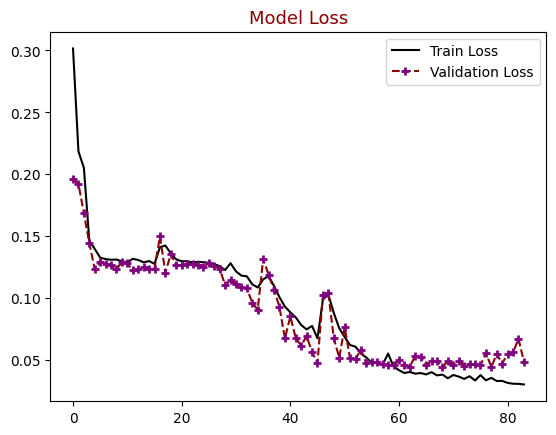

In [19]:
# Model Loss

plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "darkred", marker = "+", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()

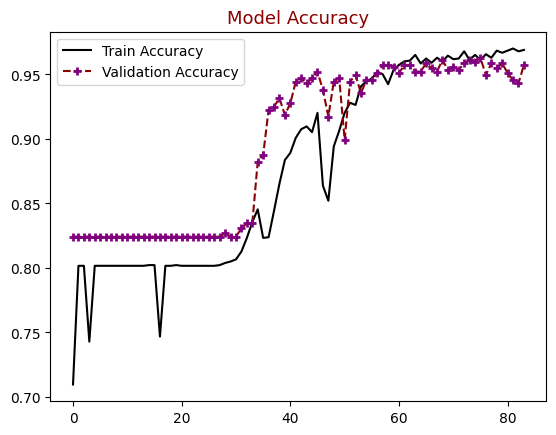

In [20]:
# Model Accuracy 

plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy", color = "darkred", marker = "+", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

In [21]:
Y_predict_test = model.predict(X_test)
print(Y_predict_test)

binary_predictions = (Y_predict_test > 0.5).astype(int)

accuracy = (binary_predictions.flatten() == y_test).mean()
unique, counts = np.unique(y_test, return_counts=True)

print(dict(zip(unique, counts)))
print(894/len(y_test))

print(f"Test accuracy: {accuracy * 100:.2f}%")

32/32 [==============================] - 0s 9ms/step
[[0.20175363]
 [0.19909725]
 [0.20181127]
 ...
 [0.19981563]
 [0.19892901]
 [0.20638297]]
{0: 894, 1: 110}
0.8904382470119522
Test accuracy: 94.72%


Test accuracy: 89.34 %

Test accuracy: 92.13 % (I don't know what changed, only the image size... 636x229)

90.74 % with initial bias

89.94 % with 1000/500, size image down 

25/25 [==============================] - 0s 7ms/step


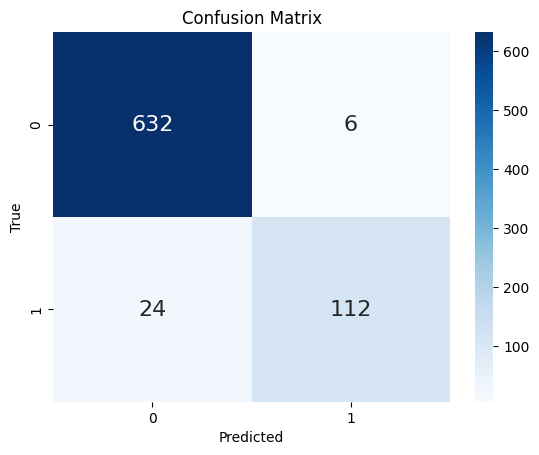

Accuracy: 96.12%
Precision: 0.9492
Recall: 0.8235
F1 Score: 0.8819


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have 'test_labels' and 'binary_predictions'
# test_labels: True labels for the test set
# binary_predictions: Predictions made by the model (0 or 1)

Y_pred = model.predict(X_val)
Y_pred_bin_list = []
for val in Y_pred:
    if val > 0.5:
        Y_pred_bin_list.append(1)
    else:
        Y_pred_bin_list.append(0)
Y_pred_bin = np.array(Y_pred_bin_list)
#print(Y_pred_bin)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(y_val, Y_pred_bin)
precision = precision_score(y_val, Y_pred_bin)
recall = recall_score(y_val, Y_pred_bin)
f1 = f1_score(y_val, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

32/32 [==============================] - 0s 7ms/step


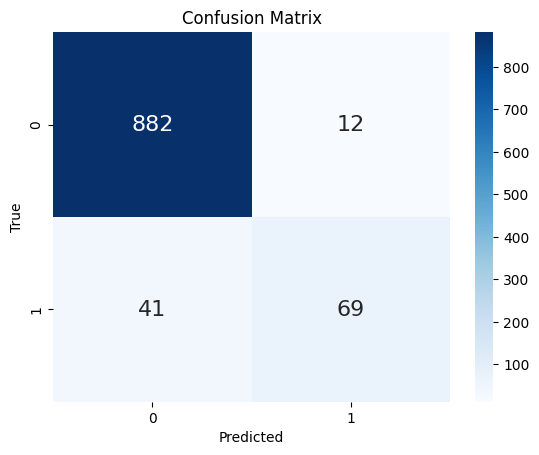

Accuracy: 94.72%
Precision: 0.8519
Recall: 0.6273
F1 Score: 0.7225


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have 'test_labels' and 'binary_predictions'
# test_labels: True labels for the test set
# binary_predictions: Predictions made by the model (0 or 1)

Y_pred = model.predict(X_test)
Y_pred_bin_list = []
for val in Y_pred:
    if val > 0.5:
        Y_pred_bin_list.append(1)
    else:
        Y_pred_bin_list.append(0)
Y_pred_bin = np.array(Y_pred_bin_list)
# print(Y_pred_bin)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(y_test, Y_pred_bin)
precision = precision_score(y_test, Y_pred_bin)
recall = recall_score(y_test, Y_pred_bin)
f1 = f1_score(y_test, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")